import packages

In [1]:
import json
import pandas as pd
import os
import glob
import re
#import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

<ipython-input-1-a785269ccd45>:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


Importation données

Nous importons les dànnées via le site:
    
http://data.montpellier3m.fr/dataset/comptages-velo-et-pieton-issus-des-eco-compteurs/resource/75f5e367-99fb-482f-ba5c   
    
    

In [2]:
# Nous utilions *.json car nous vons télécharger les données dans le me repertoire que nous traivaillons
list_files = glob.glob("*.json")
list_files

['MMM_EcoCompt_X2H19070220_Archive2020.json',
 'MMM_EcoCompt_X2H20042632_Archive2020.json',
 'MMM_EcoCompt_X2H20042633_Archive2020.json',
 'MMM_EcoCompt_X2H20042634_Archive2020.json',
 'MMM_EcoCompt_X2H20042635_Archive2020.json',
 'MMM_EcoCompt_X2H20063161_Archive2020.json',
 'MMM_EcoCompt_X2H20063162_Archive2020.json',
 'MMM_EcoCompt_X2H20063163_Archive2020.json',
 'MMM_EcoCompt_X2H20063164_Archive2020.json',
 'MMM_EcoCompt_XTH19101158_Archive2020.json']

Nous allons regrouper les données dans une seule Dataframe

In [3]:
## Lecture données
data = pd.concat([pd.read_json(i, lines=True) for i in list_files])
data.head()

,intensity,laneId,dateObserved,location,id,type,vehicleType,reversedLane
0,542,121403593,2020-01-01T00:00:00/2020-01-02T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001010000,TrafficFlowObserved,bicycle,False
1,598,121403593,2020-01-02T00:00:00/2020-01-03T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001020000,TrafficFlowObserved,bicycle,False
2,731,121403593,2020-01-03T00:00:00/2020-01-04T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001030000,TrafficFlowObserved,bicycle,False
3,793,121403593,2020-01-04T00:00:00/2020-01-05T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001040000,TrafficFlowObserved,bicycle,False
4,943,121403593,2020-01-05T00:00:00/2020-01-06T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001050000,TrafficFlowObserved,bicycle,False


In [4]:
# Donne les informations du Dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2152 entries, 0 to 294
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   intensity     2152 non-null   int64 
 1   laneId        2152 non-null   int64 
 2   dateObserved  2152 non-null   object
 3   location      2152 non-null   object
 4   id            2152 non-null   object
 5   type          2152 non-null   object
 6   vehicleType   2152 non-null   object
 7   reversedLane  2152 non-null   bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 136.6+ KB


Nous allons créer les varaibles: date, latitude et longitude

In [5]:
# Fonction pour récuperer le ieme nombre d'une chaine de caractere
def get_number(text,i):
  num = re.findall(r'\d*\.\d*',text)
  return num[i]

data['date'] = pd.to_datetime(data['dateObserved'].str[:10], format='%Y-%m-%d')
data['longitude']=data['location'].astype('str').apply(lambda x: get_number(x,0)).astype('float')
data['latitude']=data['location'].astype('str').apply(lambda x: get_number(x,1)).astype('float')

data[['date', 'latitude', 'longitude']].head()

,date,latitude,longitude
0,2020-01-01,43.609699,3.89694
1,2020-01-02,43.609699,3.89694
2,2020-01-03,43.609699,3.89694
3,2020-01-04,43.609699,3.89694
4,2020-01-05,43.609699,3.89694


Nous allons faire juste une petite répresenetation graphique du nombre de vélo par jour grace à leur id et leur date

<AxesSubplot:xlabel='date'>

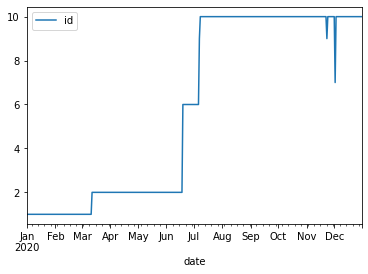

In [7]:
## NB Velos par jour : 
data_jour = data[['date', 'id']].groupby("date").agg({'id' : 'count'})
data_jour.plot()

In [19]:
import folium
px.scatter_mapbox(data, lat='latitude', lon='longitude', zoom=15)

Recuperation des différentes types d'adresse de la ville de Montpellier associéées aux coordonnées latitude et longitude

In [6]:
## Recuperer les addresses associées aux coordonnées lat, lon : 
data['geom'] = data["latitude"].map(str) + "," + data['longitude'].map(str)
locator = Nominatim(user_agent="myGeocoder", timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

tqdm.tqdm_pandas(tqdm_notebook)
data["address"] = data["geom"].progress_apply(rgeocode)
data.head()



C:\Users\NIASSE GUELADIO\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,intensity,laneId,dateObserved,location,id,type,vehicleType,reversedLane,date,longitude,latitude,geom,address
0,542,121403593,2020-01-01T00:00:00/2020-01-02T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001010000,TrafficFlowObserved,bicycle,False,2020-01-01,3.89694,43.609699,"43.60969924926758,3.896939992904663","(Passerelle du Moulin de l'Évêque, La Pompigna..."
1,598,121403593,2020-01-02T00:00:00/2020-01-03T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001020000,TrafficFlowObserved,bicycle,False,2020-01-02,3.89694,43.609699,"43.60969924926758,3.896939992904663","(Passerelle du Moulin de l'Évêque, La Pompigna..."
2,731,121403593,2020-01-03T00:00:00/2020-01-04T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001030000,TrafficFlowObserved,bicycle,False,2020-01-03,3.89694,43.609699,"43.60969924926758,3.896939992904663","(Passerelle du Moulin de l'Évêque, La Pompigna..."
3,793,121403593,2020-01-04T00:00:00/2020-01-05T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001040000,TrafficFlowObserved,bicycle,False,2020-01-04,3.89694,43.609699,"43.60969924926758,3.896939992904663","(Passerelle du Moulin de l'Évêque, La Pompigna..."
4,943,121403593,2020-01-05T00:00:00/2020-01-06T00:00:00,"{'coordinates': [3.896939992904663, 43.6096992...",MMM_EcoCompt_X2H19070220_202001050000,TrafficFlowObserved,bicycle,False,2020-01-05,3.89694,43.609699,"43.60969924926758,3.896939992904663","(Passerelle du Moulin de l'Évêque, La Pompigna..."


In [7]:
data['address'].astype('str').value_counts()

Passerelle du Moulin de l'Évêque, La Pompignane, Port Marianne, Montpellier, Hérault, Occitanie, France métropolitaine, 34064, France                              366
Avenue François Delmas, Les Aubes, Centre, Montpellier, Hérault, Occitanie, France métropolitaine, 3400, France                                                    355
Site Saint-Charles - Annexe Montpellier 3, Rue Professeur Henri Serre, Boutonnet, Centre, Montpellier, Hérault, Occitanie, France métropolitaine, 34000, France    295
Quick, Avenue Georges Frêche, Pailletrice, Pérols, Montpellier, Hérault, Occitanie, France métropolitaine, 34470, France                                           196
Kiloutou, Avenue Georges Frêche, Pailletrice, Pérols, Montpellier, Hérault, Occitanie, France métropolitaine, 34470, France                                        196
D 5, Lavérune, Montpellier, Hérault, Occitanie, France métropolitaine, 34880, France                                                                               19

In [8]:
# Mettre des codes sur les adresses au lieu des noms 
loc = data['address'].astype('str').unique().tolist()
code_location = { x : str(y) for x,y in zip(loc, range(len(loc)))}

<ipython-input-9-278af4a4dedd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['address'] = data_local['address'].astype('str')
<ipython-input-9-278af4a4dedd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_local['address'] = data_local['address'].map(code_location)


<AxesSubplot:xlabel='address'>

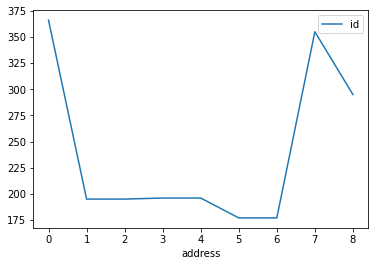

In [9]:
## NB Velos par adresse : 
data_local = data[['address', 'id']]
data_local['address'] = data_local['address'].astype('str')
data_local['address'] = data_local['address'].map(code_location)
data_local.groupby("address").agg({'id' : 'count'}).plot()

In [16]:
data.to_excel('/content/drive/My Drive/Data science/Projets Niasse/velos_viz/data/all_data.xlsx')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 5-6: malformed \N character escape (<ipython-input-16-06df479afbfc>, line 1)